In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print(columns)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [10]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23 00:00:00


,station,prcp,tobs
date,,,
2016-08-24,USC00519397,0.08,79.0
2016-08-24,USC00513117,2.15,76.0
2016-08-24,USC00514830,2.28,80.0
2016-08-24,USC00517948,NaN,78.0
2016-08-24,USC00519523,1.22,79.0
...,...,...,...
2017-08-22,USC00516128,0.50,76.0
2017-08-23,USC00519397,0.00,81.0
2017-08-23,USC00514830,0.00,82.0


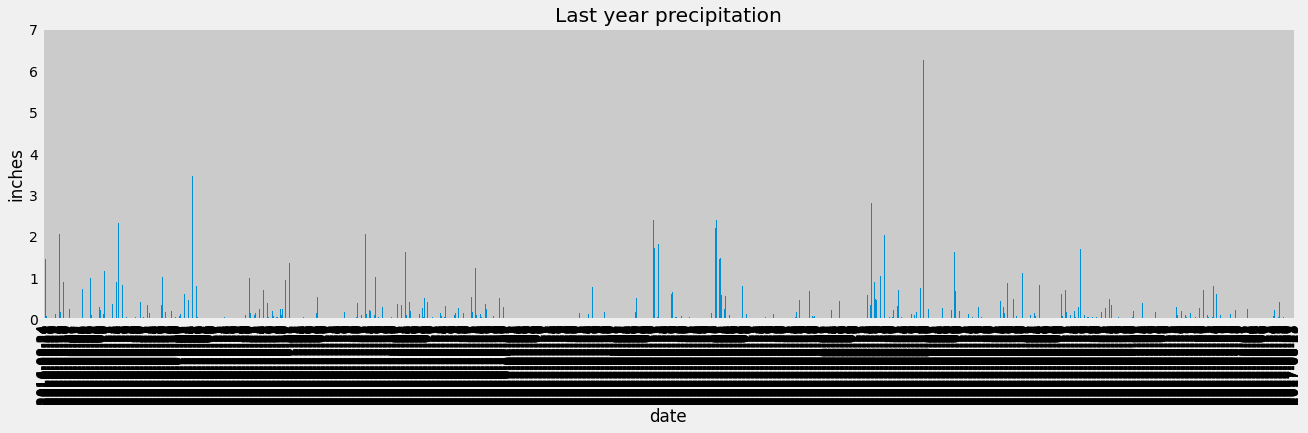

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# session.query(func.count(Measurement.date)).all()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Converting date in string format into datetime object
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
last_year = last_date - dt.timedelta(days=365)
print(last_year)

# Perform a query to retrieve the data and precipitation scores
query1 = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= last_year).order_by(Measurement.date).all()
# for row in query1:
#     print(row)
    
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.read_sql(session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= last_year).order_by(Measurement.date).statement, engine)

# Sort the dataframe by date
# last_year_df = last_year_df.groupby('date').mean()
last_year_df = last_year_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
# fig, ax = plt.subplots()
last_year_df['prcp'].plot(kind = "bar", title = "Last year precipitation", ylabel = "inches",figsize = (20,5))
last_year_df

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,prcp,tobs
count,2015.000000,2223.000000
mean,0.176462,74.578947
std,0.460288,4.612232
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
print(columns)

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


In [14]:
# Design a query to show how many stations are available in this dataset?
station_list1 = session.query(Station.station).all()
print(len(station_list1))

station_list2 = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_list2)

9
9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sts_dict = {}

for sts in station_list1:
    sts_dict[sts[0]] = session.query(Measurement.date).filter(Measurement.station == sts[0]).count()

max_sts = max(sts_dict, key=sts_dict.get)
print(f"The max value is {max_sts}: {sts_dict[max_sts]}.")

The max value is USC00519281: 2772.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == max_sts).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<AxesSubplot:title={'center':'Observed Temperature [F]'}, ylabel='Frequency'>

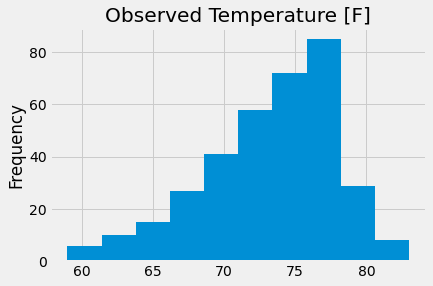

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query2 = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == max_sts).order_by(Measurement.date).all()
last_year_df_max_sts = pd.read_sql(session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == max_sts).order_by(Measurement.date).statement, engine)
last_year_df_max_sts["tobs"].plot(kind = "hist", title = "Observed Temperature [F]")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
